In [58]:
# -*- coding: future_fstrings -*-

import os
from time import time
import datetime

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input as MobileNet_preprocess_input
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input as VGG19_preprocess_input
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input as InceptionResNetV2_preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as InceptionV3_preprocess_input
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input as MobileNetV2_preprocess_input
from keras.applications.nasnet import NASNetLarge
from keras.applications.nasnet import preprocess_input as NASNetLarge_preprocess_input

from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, \
    GlobalAveragePooling2D, GlobalMaxPooling2D, AvgPool2D, Lambda, \
    Dropout, GlobalAveragePooling2D, multiply, LocallyConnected2D, \
    BatchNormalization
from keras.models import Sequential, Model
from keras.callbacks import TensorBoard, ModelCheckpoint, \
    LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
import tensorflow as tf

In [38]:
import numpy as np

import data_preparation
import params
import reset
import gradient_accumulation
from utils import plot_train_metrics, save_model
import glob

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

RUN_TIMESTAMP = datetime.datetime.now().isoformat('-')

In [39]:
import os
os.chdir('/data/road-scanner/')

In [40]:
metadata = data_preparation.load_metadata()
metadata, labels = data_preparation.preprocess_metadata(metadata)
train, valid = data_preparation.stratify_train_test_split(metadata)

Total records:29364.
             path
label            
non-scenic   7250
scenic      22114
Balancing data
            path
label           
non-scenic  7250
scenic      7250
Total records:14500.


In [41]:
optimizer = 'adam'
base_models = [
        [VGG19, params.VGG19_IMG_SIZE, VGG19_preprocess_input],
        #[MobileNet, params.MOBILENET_IMG_SIZE, MobileNet_preprocess_input],
        #[InceptionResNetV2, params.INCEPTIONRESNETV2_IMG_SIZE,
        # InceptionResNetV2_preprocess_input],
        
        #[InceptionV3, params.INCEPTIONV3_IMG_SIZE, InceptionV3_preprocess_input],
        #[MobileNetV2, params.MOBILENETV2_IMG_SIZE, MobileNetV2_preprocess_input],
        #[NASNetLarge, params.NASNETLARGE_IMG_SIZE, NASNetLarge_preprocess_input],
    ]
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [75]:
def plot_attention_map(_Model, input_shape, transfer_learing,
                preprocessing_function,
                train, valid, labels,
                extend_model_callback, optimizer,
                name_prefix, weights="imagenet"):

    test_X, test_Y = next(create_data_generator(
        valid, labels, 100, None, target_size=input_shape))
    
    baseModel = _create_base_model(_Model,
                                   labels,
                                   test_X.shape[1:],
                                   trainable=False,
                                   weights=None)

    model = extend_model_callback(baseModel, labels, optimizer)
    model_name = name_prefix+'_' + baseModel.name

    weights = os.path.join(params.RESULTS_FOLDER,
                           model_name, '*weights.best.hdf5')
    
    best_weights = glob.glob(weights)
    best_weights.sort()
    weights = best_weights[0]
    
    print('Loading '+weights)
    model.load_weights(weights, by_name=True)
    model.trainable = False

    # Get the attention model first
    for attention_model in model.layers:
        c_shape = attention_model.get_output_shape_at(0)
        if c_shape[-1]==13:
            break
    # now get the attention layer
    for attention_layer in attention_model.layers:
        c_shape = attention_layer.get_output_shape_at(0)
        if len(c_shape)==4:
            if c_shape[-1]==1:
                break

    rand_idx = np.random.choice(range(len(test_X)), size = 12)
    attention_function = K.function(inputs = [attention_model.get_input_at(0), K.learning_phase()],
               outputs = [attention_layer.get_output_at(0)]
              )
    fig, m_axs = plt.subplots(len(rand_idx), 2, figsize = (8, 4*len(rand_idx)))
    [c_ax.axis('off') for c_ax in m_axs.flatten()]
    
    labels = np.array(labels)
    
    for c_idx, (img_ax, attn_ax) in zip(rand_idx, m_axs):
        cur_img = test_X[c_idx:(c_idx+1)]
        cur_features = baseModel.predict(cur_img)
        attn_img = attention_function([cur_features, 0])[0]
        img_ax.imshow(cur_img[0,:,:,0], cmap = 'bone')
        attn_ax.imshow(attn_img[0, :, :, 0], cmap = 'viridis', 
                       vmin = 0, vmax = 1, 
                       interpolation = 'lanczos')
        real_label = test_Y[c_idx]
        
        indices=np.argwhere(np.array(real_label) > 0.5).ravel()
        img_ax.set_title('Classes\n%s' % (labels[indices]))
        pred_confidence = model.predict(cur_img)[0]
        pred_confidence = np.array(pred_confidence)
        
        pred_confidence = pred_confidence[:].astype(float)
        pred_confidence = 100*pred_confidence
        string_confidence = ''
        for index in indices:
            string_confidence = string_confidence + '%2.1f%% ' % (pred_confidence[index])
        #print(string_confidence)
        attn_ax.set_title('Attention Map\nConfidence:'+string_confidence)
    
    attention_figure = os.path.join(params.RESULTS_FOLDER, model_name, 'attention_map.png')
    fig.savefig(attention_figure, dpi = 300)
    
    print('Saved plot at '+ attention_figure)
    tf.summary.image("Attention_maps", plot_to_image(fig))
    
    return fig

Found 3625 images belonging to 2 classes.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
attention_model (Model)      (None, 2)                 138819    
Total params: 20,163,203
Trainable params: 137,283
Non-trainable params: 20,025,920
_________________________________________________________________
None
Loading networks/.results/attention_vgg19/0.17_weights.best.hdf5
Saved plot at networks/.results/attention_vgg19/attention_map.png


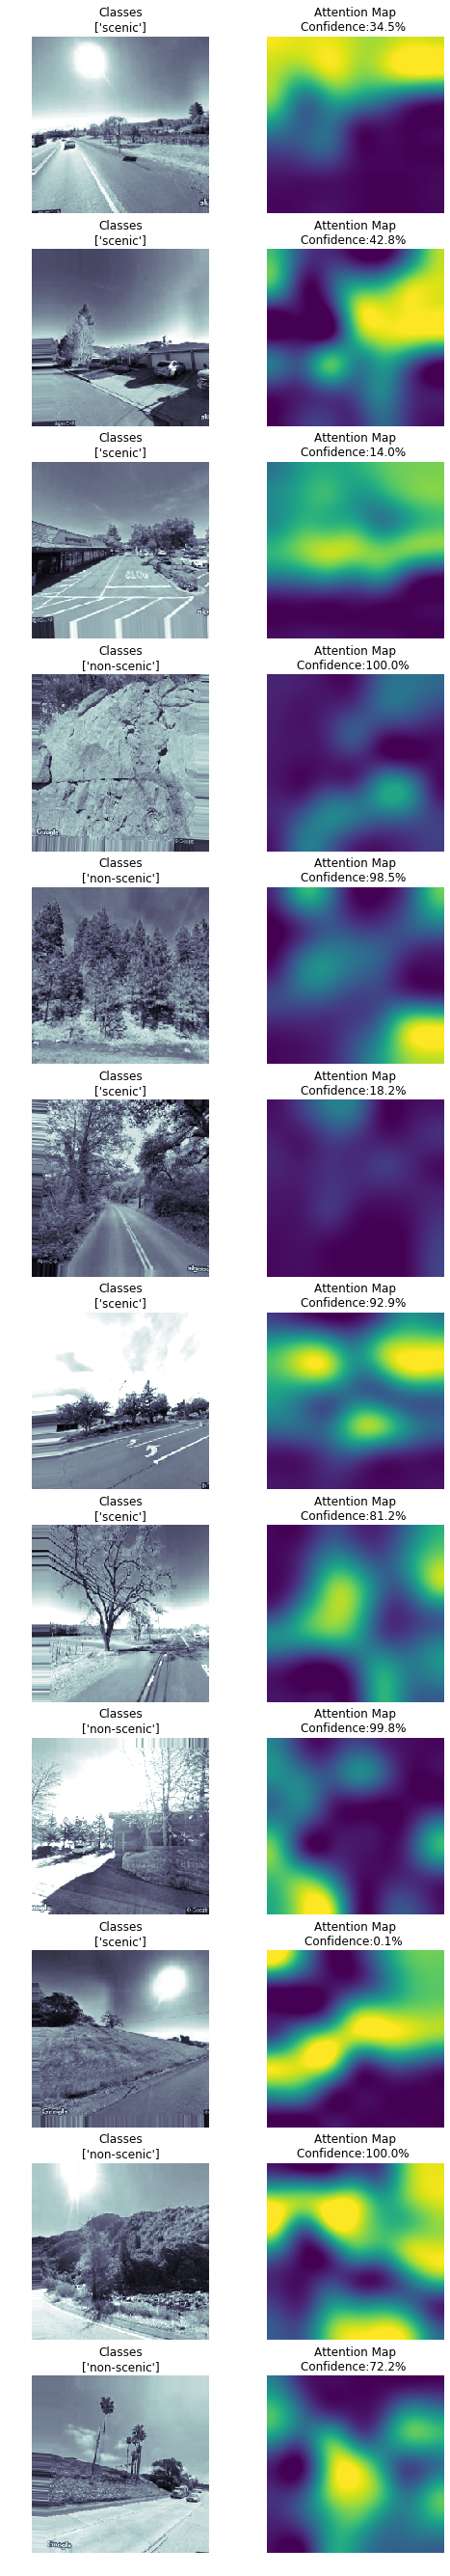

In [85]:
# for these image sizes, we don't need gradient_accumulation to achieve BATCH_SIZE = 256
import io
optimizer = 'adam'

custom_layers = [
    [create_attention_model, 'attention']
]

def plot_to_image(figure):
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    #plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

for [custom_layer, name_prefix] in custom_layers:
    for [_Model, input_shape, preprocess_input] in base_models:
        plot_attention_map(_Model, input_shape, True , preprocess_input,
                    train, valid, labels,
                    custom_layer, optimizer, name_prefix)

#with tf.Session() as sess:       
#    file_writer = tf.summary.FileWriter('/data/road-scanner/networks/.results/tensorboard', tf.Session().graph)
#    merged = tf.summary.merge_all()
#    summary = sess.run(merged)
#    file_writer.add_summary(summary)
    